# Predicting whether Ethereum Daily Returns will be Positive or Negative

Cryptocurrencies have become an incredible source of speculation and investment. However, the cryptocurrency space is also inherently challenging to analyze, much less predict.

Bitcoin first created this market in 2008. An unnamed person or persons made the first immutable asset. What does that mean? It became the first digital object that cannot be copied, duplicated, pirated, or forged. Its immutable nature results from its core decentralization tenet. Transactional information is stored across a network of machines rather than with one sole entity or person.

I should say remind everyone that Bitcoin's "validity" is still hotly debated. Partly because there isn't a large enough consensus regarding what Bitcoin should be. Is it an asset, a store of value, a potential currency? The answers and interpretations span the gambit. Regardless Bitcoin opened the door for the inception of hundreds, if not thousands, of new cryptocurrencies. We'll be examining one of them today: Etheruem.

Ethereum is a decentralized, open-source blockchain featuring smart contract functionality. Ether (ETH) is the native cryptocurrency of the platform. It is the second-largest cryptocurrency by market capitalization, after Bitcoin. Ethereum is the most actively used blockchain. (https://en.wikipedia.org/wiki/Ethereum)

Historically, Bitcoin has been extremely volatile and difficult to predict. However, the hope is that we might fare better at determining whether the price movement of ETH would create positive or negative returns instead of placing our focus on Bitcoin.

We'll be attempting to use various other currencies, including Bitcoin and some of their relevant technical indicators. These indicators were inspired by a paper which can be found here: (https://c.mql5.com/forextsd/forum/224/Predicting%20the%20direction%20of%20stock%20market%20prices%20using%20random%20forest.pdf).


##DATA:
Data was sourced from http://www.cryptodatadownload.com/ via their Bitstamp exchange aggregate reports. Currencies include ETH, Bitcoin, Litcoin, XRP, and BitcoinCash

We are of course dealing with a time series, so if you try to replicate these results be cognizant of a few things.

1. Cryptocurrencies and stock price movements can be highly stochastic and of-course non-stationary. Your modelling techniques will have to account for this.
2. If you use Sklearn's train_test_split, make sure to set "shuffle=False", otherwise you'll compromise your time series validation set
3. Attempting to predict cryptocurrency or stock prices is an incredibly ardous and involved task. You should be cautious of  anyone, or anything showing you 70-99% accuracy(when classifying) solely by applying some ML algos, or a deep neural network. If it were only that easy. I'm not saying it isn't possible, but this notebook is the culmination of only a week's worth of work, so it won't be used to take the HedgeFunds to the cleaners anytime soon.

##TARGET: Log Returns
Why try to predict returns instead of price? Price can theoretically be an infinitely continous value, making it very difficult to pinpoint. Typically, predictions with stocks are done based on a lag differencing or returns. As such, we have opted for returns, because it gives us the opportunity to frame the experiment as a classification task.


##Models: 
We will mostly focus on ensemble models. But we do explore an LSTM neural network at the end of the notebook.

1. Random Forest Classifier
2. XGBoost Classifier
3. LSTM RNN



# Import Relevant Libraries

In [1]:
!pip install pandas-ta -U git+https://github.com/twopirllc/pandas-ta --quiet

     |████████████████████████████████| 81kB 3.5MB/s 


In [41]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import math
import time
import ssl
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from functools import reduce

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten, Bidirectional
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping

from scipy.stats import uniform, truncnorm, randint

from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, RepeatedKFold, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, f1_score,auc,roc_curve,roc_auc_score, log_loss, make_scorer, precision_recall_curve, plot_roc_curve

from xgboost import XGBClassifier

import warnings
def fxn():
    warnings.warn(DeprecationWarning)
    warnings.warn(FutureWarning)
    warnings.warn(RuntimeWarning) # creating log_return values for 0's in the df returns this warning

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Read in data

In [3]:
# Bitstamp exchange source
btc_filepath = 'http://www.cryptodatadownload.com/cdd/Bitstamp_BTCUSD_d.csv'
eth_filepath = 'http://www.cryptodatadownload.com/cdd/Bitstamp_ETHUSD_d.csv'
ltc_filepath = 'http://www.cryptodatadownload.com/cdd/Bitstamp_LTCUSD_d.csv'
xrp_filepath = 'http://www.cryptodatadownload.com/cdd/Bitstamp_XRPUSD_d.csv'
bch_filepath = 'http://www.cryptodatadownload.com/cdd/Bitstamp_BCHUSD_d.csv'

ssl._create_default_https_context = ssl._create_unverified_context

# Preprocess Data

In [4]:
# Create dataframe preprocessing function
def pre_processing(df):
  df = df.iloc[:, [1, 3, 4, 5, 6, 8]].sort_values('date')
  df['date'] = pd.to_datetime(df.date)
  df = df.rename(columns={'Volume USD': 'volume'})
  df = df.set_index('date')
  df.ta.log_return(append=True)
  df.ta.stoch(k=14, d=3, smooth_k=3, append=True)
  df.ta.willr(length=14, append=True)
  df.ta.rsi(length=14, scalar=100, append=True)
  df.ta.macd(append=True)
  df.ta.roc(length=1, append=True)
  df.ta.zscore(length=30, std=3, append=True)
  preprocessed_df = df.copy()
  return preprocessed_df

We will be incorporating several indicators for each currency into our dataframe. We arrived at these indicators as a suggestion from this paper: (https://c.mql5.com/forextsd/forum/224/Predicting%20the%20direction%20of%20stock%20market%20prices%20using%20random%20forest.pdf)

The indicators are:

1. Log Returns
2. Stochastic Oscillator
> Momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time.
3. Williams %R
> Ranges from -100 to 0. When its value is above -20, it indicates a sell signal and when its value is below -80, it indicates a buy signal
4. MACD
> Moving average convergence divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. 
5. Relative Strength Indicator (RSI)
> Momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.
6. Price Rate of Change (ROC)
> Momentum-based technical indicator that measures the percentage change in price between the current price and the price a certain number of periods ago. 
7. Zscore
> Measures the difference between the closing price from n-period moving average given the n-period standard deviation.

Documentation for Pandas-ta library cna be found here: https://github.com/twopirllc/pandas-ta

In [5]:
# Create df using preprocessing function
btc_df = pd.read_csv(btc_filepath, skiprows=1)
btc = pre_processing(btc_df).add_prefix('BTC_')

eth_df = pd.read_csv(eth_filepath, skiprows=1)
eth = pre_processing(eth_df).add_prefix('ETH_')

ltc_df = pd.read_csv(ltc_filepath, skiprows=1)
ltc = pre_processing(ltc_df).add_prefix('LTC_')

xrp_df = pd.read_csv(xrp_filepath, skiprows=1)
xrp = pre_processing(xrp_df).add_prefix('XRP_')

bch_df = pd.read_csv(bch_filepath, skiprows=1)
bch = pre_processing(bch_df).add_prefix('BCH_')
#Errors occur because the log transformation on returns is attempted, 
#we'll be filtering out those 0 values, so it's nothing to worry about

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/pandas/core/algorithms.py:2001: RuntimeWarning:

invalid value encountered in subtract

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/pandas/core/algorithms.py:2001: RuntimeWarning:

invalid value encountered in subtract

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/pandas/core/algorithms.py:2001: RuntimeWarning:

invalid value encountered in subtract

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/pandas/core/algorithms.py:2001: RuntimeWarning:

invalid value encountered in subtract



## Visualizing the components of our time series

In [6]:
series = eth[eth['ETH_close'] != 0.00][1:]
series = series[['ETH_close']]
decomposition = sm.tsa.seasonal_decompose(series, model='additive')

trend = decomposition.trend.reset_index()
seasonality = decomposition.seasonal.reset_index()
residuals = decomposition.resid.reset_index()

merged = series.merge(trend, on='date')
merged = merged.merge(seasonality, on='date')
merged = merged.merge(residuals, on='date')
merged.columns = ['Date', 'Observed', 'Trend', 'Seasonality', 'Residuals']

In [7]:
melted = pd.melt(merged, 
                id_vars='Date', 
                value_vars=['Observed', 'Trend', 'Seasonality', 'Residuals'], 
                var_name='Variable', 
                value_name='Price')

px.line(melted, x='Date', y='Price', color='Variable')

## Observations:

1. A trend is evident
2. Residuals do not appear to be homoscedastic

##Visualizing the log returns of Ethereum

We can observe several clusters of volatility which is to be expected with any cryptocurrency.

In [8]:
eth_returns = eth['ETH_LOGRET_1'].dropna(axis=0).reset_index()[1:]
px.line(eth_returns, x='date', y='ETH_LOGRET_1')

### Finding correlations

We will attempt to get a high-level view of how the different ETH indicators interact with ETH Log_Returns via their correlation coefficients.

In [9]:
#Make a scatter plot with square markers

def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

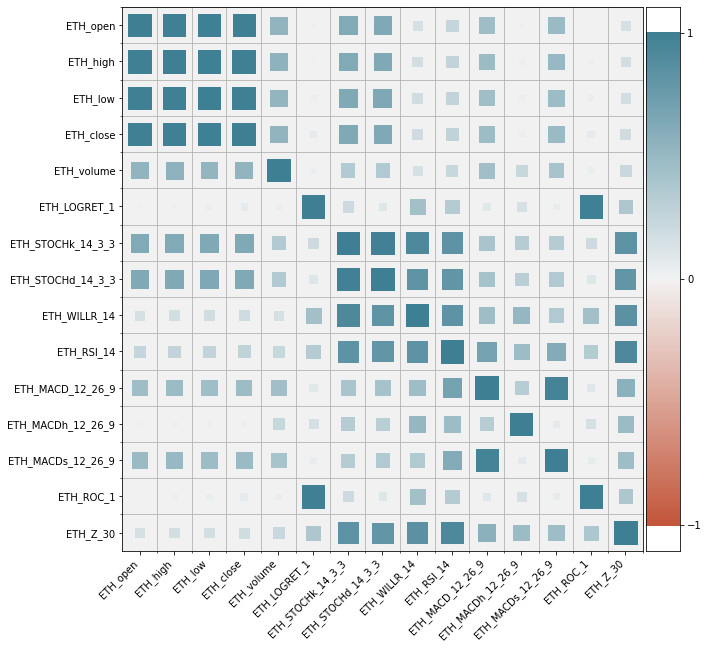

In [10]:
corr = eth.corr()
plt.figure(figsize=(10, 10))
corrplot(corr)

**Rate of Change** appears to have a strong positive correlation with ETH returns. Followed by the **WILLR** indicator.

## Create master dataframe of all cryptocurrencies to be analyzed

In [11]:
#Create iterable list of df names
data_frames = [btc, eth, ltc, xrp, bch]

# Merge all currency dataframes on the date index, and reverse the order of the dataframe (from oldest to most recent date)
merged_df = reduce(lambda left,right: pd.merge(left,right,on=['date'], how='outer'), data_frames)[::-1].dropna(axis=0)[::-1]

# Drop the first row as the Rate of Change column held some Nan values
crypto_df =  merged_df.copy()[1::]

Let's take a look at whole dataset, and try to visually observe any strong correlation coefficients.

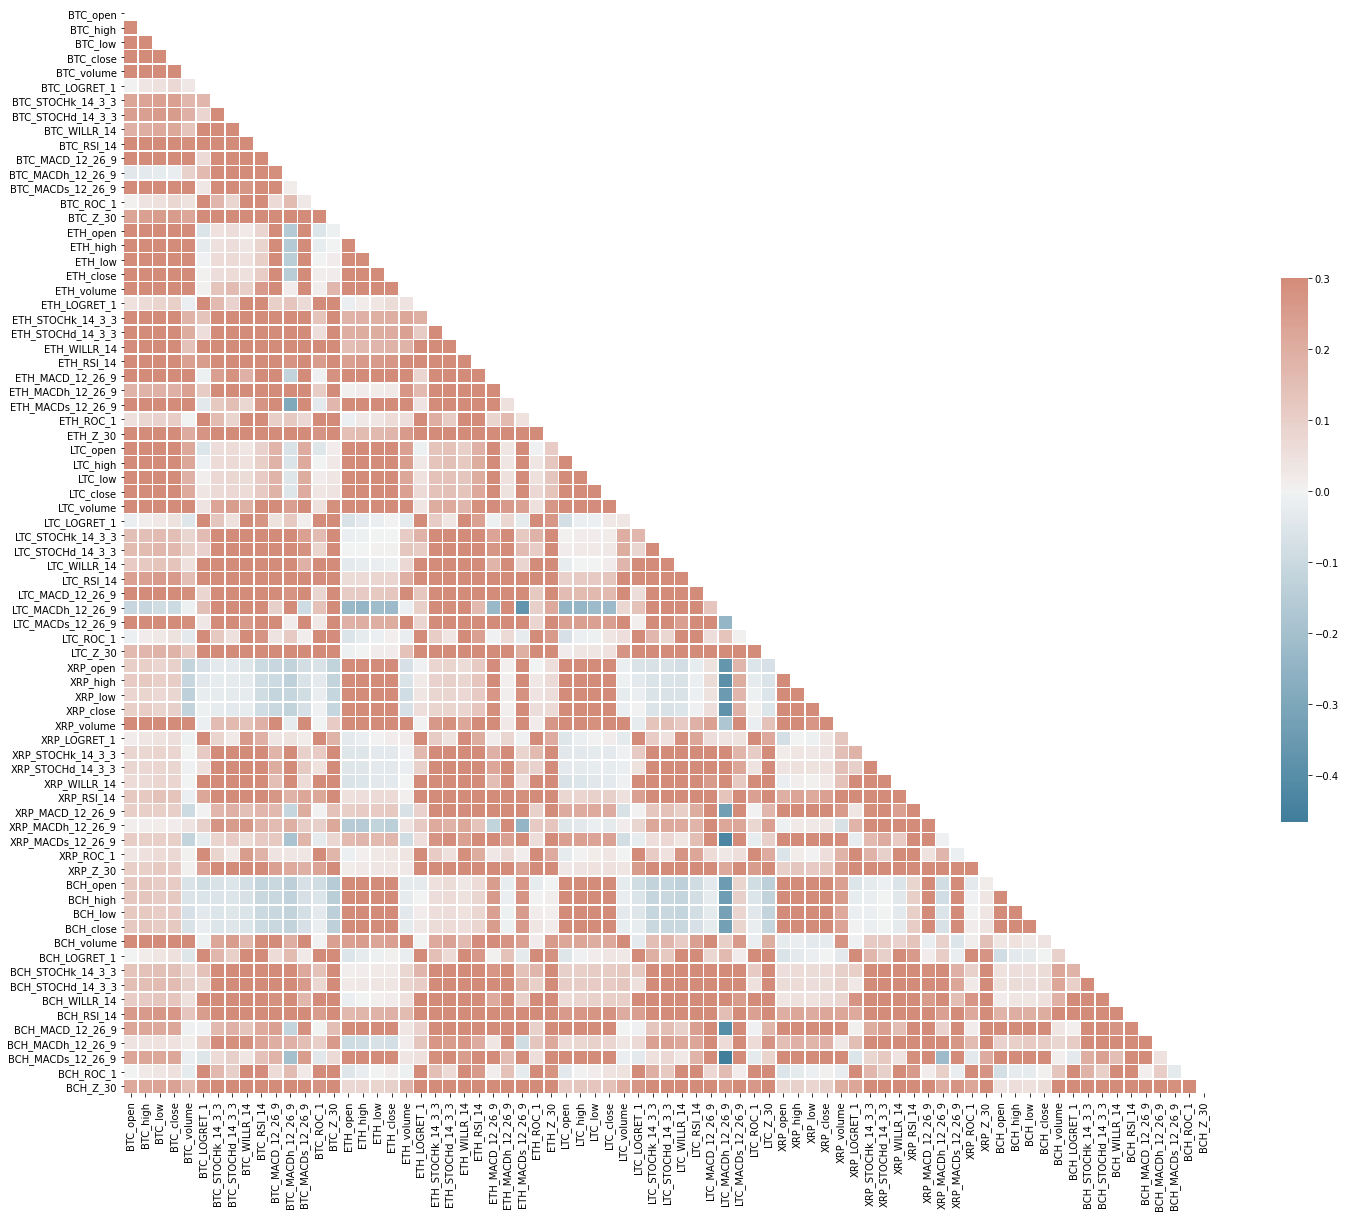

In [12]:
corr = crypto_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Interestingly, several BTC metrics and indicators seem to present a strong correlation with ETH returns. But it's difficult to examine from this scope so, let's zoom in.

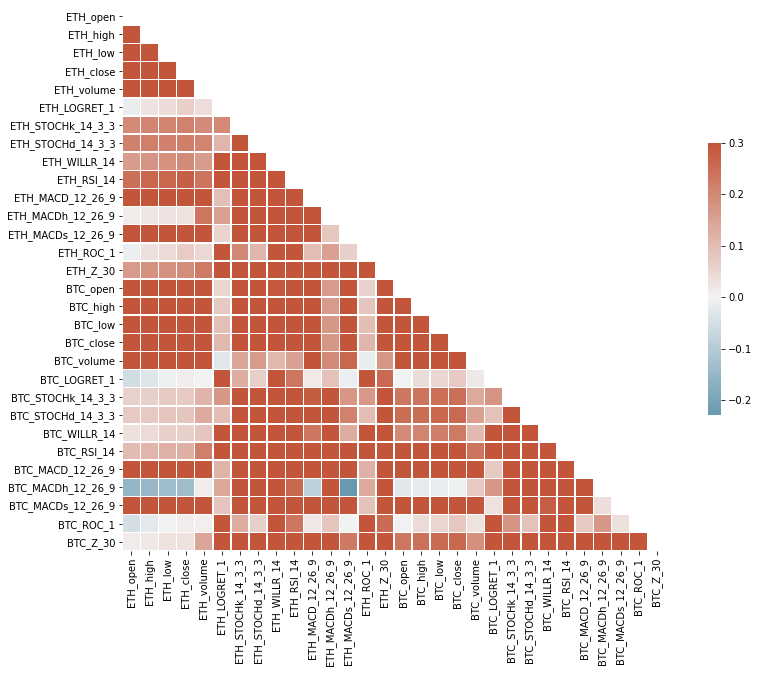

In [13]:
#Create joined BTC and ETH dataframe
btc_eth = eth.join(btc).dropna(axis=0)[1:]

corr = btc_eth.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Here we can more clearly see that several BTC indicators interact positively with ETH Log_Returns. 

Let's see what the most highly correlated indicators look like alongside each other.

In [14]:
btc_eth = btc_eth.reset_index()

melted = pd.melt(btc_eth, id_vars='date', value_vars=['ETH_close', 
                                                      'ETH_LOGRET_1', 
                                                      'BTC_Z_30', 
                                                      'BTC_ROC_1', 
                                                      'BTC_RSI_14', 
                                                      'BTC_WILLR_14',
                                                      'BTC_MACD_12_26_9',
                                                      'BTC_MACDs_12_26_9', 
                                                      'BTC_LOGRET_1',
                                                      'ETH_Z_30',
                                                      'ETH_ROC_1',
                                                      'ETH_RSI_14',
                                                      'ETH_WILLR_14',
                                                      'BTC_MACDs_12_26_9'], 
                var_name='Variable', value_name='Value')
px.line(melted, 'date', 'Value', color='Variable', title= 'ETH Closing Price and Returns vs BTC')

Visually there's not much to extract from this time range, but feel free to play around with the variables.

# More Data Processing

In [15]:
#Create binary classifier to reflect, whether ETH log_return was positive or 
# negative for that day
crypto_df['IsETHReturnPositive'] = np.sign(crypto_df['ETH_LOGRET_1'])
#1 reflects positive return | -1 reflects negative returns

In [16]:
crypto_df.head()

,BTC_open,BTC_high,BTC_low,BTC_close,BTC_volume,BTC_LOGRET_1,BTC_STOCHk_14_3_3,BTC_STOCHd_14_3_3,BTC_WILLR_14,BTC_RSI_14,BTC_MACD_12_26_9,BTC_MACDh_12_26_9,BTC_MACDs_12_26_9,BTC_ROC_1,BTC_Z_30,ETH_open,ETH_high,ETH_low,ETH_close,ETH_volume,ETH_LOGRET_1,ETH_STOCHk_14_3_3,ETH_STOCHd_14_3_3,ETH_WILLR_14,ETH_RSI_14,ETH_MACD_12_26_9,ETH_MACDh_12_26_9,ETH_MACDs_12_26_9,ETH_ROC_1,ETH_Z_30,LTC_open,LTC_high,LTC_low,LTC_close,LTC_volume,LTC_LOGRET_1,LTC_STOCHk_14_3_3,LTC_STOCHd_14_3_3,LTC_WILLR_14,LTC_RSI_14,LTC_MACD_12_26_9,LTC_MACDh_12_26_9,LTC_MACDs_12_26_9,LTC_ROC_1,LTC_Z_30,XRP_open,XRP_high,XRP_low,XRP_close,XRP_volume,XRP_LOGRET_1,XRP_STOCHk_14_3_3,XRP_STOCHd_14_3_3,XRP_WILLR_14,XRP_RSI_14,XRP_MACD_12_26_9,XRP_MACDh_12_26_9,XRP_MACDs_12_26_9,XRP_ROC_1,XRP_Z_30,BCH_open,BCH_high,BCH_low,BCH_close,BCH_volume,BCH_LOGRET_1,BCH_STOCHk_14_3_3,BCH_STOCHd_14_3_3,BCH_WILLR_14,BCH_RSI_14,BCH_MACD_12_26_9,BCH_MACDh_12_26_9,BCH_MACDs_12_26_9,BCH_ROC_1,BCH_Z_30,IsETHReturnPositive
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-29,14470.07,15111.00,13998.00,14340.00,13505.70,-0.009030,41.912070,44.903515,-62.614110,48.972951,536.220898,-526.783269,1063.004167,-0.898890,-0.080708,717.23,758.00,709.00,732.67,44816.84,0.021299,61.940379,63.414237,-37.216802,62.158924,70.247333,-12.496003,82.743336,2.152726,0.282912,249.95,258.80,236.43,240.00,58343.45,-0.040622,38.644943,43.978630,-67.057421,51.112725,28.282064,-13.364941,41.647006,-3.980796,0.069449,1.255,1.974,1.255,1.930,1.429739e+08,0.430384,94.125011,88.430748,-3.298351,88.392904,0.283433,0.075375,0.208058,53.784861,0.972588,2498.00,2895.00,2298.57,2600.00,11900.50,0.040021,63.096111,32.085183,-10.189983,100.000000,361.260250,257.124895,104.135355,4.083267,1.252275,1.0
2017-12-30,14340.00,14463.28,12050.00,12640.00,21749.67,-0.126186,31.233695,40.213296,-82.599838,41.535175,296.739999,-613.011334,909.751334,-11.854951,-0.340157,732.67,740.72,659.06,698.46,59596.87,-0.047817,58.298103,61.280939,-46.487805,57.117486,63.791645,-15.161353,78.952998,-4.669224,0.186140,240.00,242.53,200.00,211.17,103142.87,-0.127975,29.816544,37.854604,-81.377906,44.986480,21.814883,-15.865698,37.680581,-12.012500,-0.051828,1.930,2.474,1.770,1.889,1.412318e+08,-0.021472,86.094139,89.657746,-31.897492,85.933702,0.323201,0.092114,0.231087,-2.124352,0.811860,2600.00,2628.91,2120.00,2240.42,9515.13,-0.148848,88.892542,61.716031,-22.610708,86.213386,455.373803,280.990759,174.383044,-13.830000,0.889430,-1.0
2017-12-31,12640.00,14296.06,12491.21,13880.00,11583.42,0.093583,29.511175,34.218980,-66.252526,47.766667,204.648241,-564.082474,768.730715,9.810127,-0.188246,698.46,759.08,687.03,743.48,24771.96,0.062464,60.669377,60.302620,-34.287263,61.538431,61.598138,-13.883888,75.482026,6.445609,0.275048,211.17,235.00,208.19,227.16,38665.49,0.072991,26.043115,31.501534,-73.435327,48.661794,17.774957,-15.924499,33.699456,7.572098,-0.008289,1.889,2.099,1.610,1.990,5.297524e+07,0.052087,79.471251,86.563467,-26.390403,86.900538,0.358732,0.102116,0.256616,5.346744,0.769596,2240.42,2504.00,2189.00,2377.00,3199.33,0.059176,83.102130,78.363594,-17.892919,86.949365,534.815319,288.345820,246.469499,6.096178,0.813533,1.0
2018-01-01,13880.00,13941.75,12801.38,13443.41,7688.03,-0.031960,26.562689,29.102520,-71.459568,45.911202,95.336712,-538.715202,634.051914,-3.145461,-0.282526,743.48,768.87,722.02,752.78,29181.94,0.012431,62.485998,60.484493,-31.766938,62.400766,59.919485,-12.450032,72.369518,1.250874,0.278361,227.16,232.99,215.17,223.57,27976.08,-0.015930,23.322737,26.394132,-75.218558,47.888251,14.120827,-15.662904,29.783730,-1.580384,-0.040181,1.990,2.090,1.810,2.040,2.849404e+07,0.024815,72.595692,79.387028,-23.925028,87.363589,0.386470,0.103884,0.282587,2.512563,0.711055,2377.00,2410.00,2250.00,2310.00,2772.40,-0.028592,79.763040,83.919237,-20.207254,84.564475,585.616333,271.317466,314.298866,-2.818679,0.696855,1.0
2018-01-02,13443.41,15257.53,12910.58,14678.94,16299.67,0.087925,38.037911,31

In [17]:
# Create Target variable (predicting one day into the future by shifting the returns classified back one)
crypto_df['Target'] = crypto_df['IsETHReturnPositive'].shift(-1)
target_df = crypto_df[['Target']]

In [18]:
final_df = crypto_df.dropna(axis=0)
final_df.head()

,BTC_open,BTC_high,BTC_low,BTC_close,BTC_volume,BTC_LOGRET_1,BTC_STOCHk_14_3_3,BTC_STOCHd_14_3_3,BTC_WILLR_14,BTC_RSI_14,BTC_MACD_12_26_9,BTC_MACDh_12_26_9,BTC_MACDs_12_26_9,BTC_ROC_1,BTC_Z_30,ETH_open,ETH_high,ETH_low,ETH_close,ETH_volume,ETH_LOGRET_1,ETH_STOCHk_14_3_3,ETH_STOCHd_14_3_3,ETH_WILLR_14,ETH_RSI_14,ETH_MACD_12_26_9,ETH_MACDh_12_26_9,ETH_MACDs_12_26_9,ETH_ROC_1,ETH_Z_30,LTC_open,LTC_high,LTC_low,LTC_close,LTC_volume,LTC_LOGRET_1,LTC_STOCHk_14_3_3,LTC_STOCHd_14_3_3,LTC_WILLR_14,LTC_RSI_14,LTC_MACD_12_26_9,LTC_MACDh_12_26_9,LTC_MACDs_12_26_9,LTC_ROC_1,LTC_Z_30,XRP_open,XRP_high,XRP_low,XRP_close,XRP_volume,XRP_LOGRET_1,XRP_STOCHk_14_3_3,XRP_STOCHd_14_3_3,XRP_WILLR_14,XRP_RSI_14,XRP_MACD_12_26_9,XRP_MACDh_12_26_9,XRP_MACDs_12_26_9,XRP_ROC_1,XRP_Z_30,BCH_open,BCH_high,BCH_low,BCH_close,BCH_volume,BCH_LOGRET_1,BCH_STOCHk_14_3_3,BCH_STOCHd_14_3_3,BCH_WILLR_14,BCH_RSI_14,BCH_MACD_12_26_9,BCH_MACDh_12_26_9,BCH_MACDs_12_26_9,BCH_ROC_1,BCH_Z_30,IsETHReturnPositive,Target
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-29,14470.07,15111.00,13998.00,14340.00,13505.70,-0.009030,41.912070,44.903515,-62.614110,48.972951,536.220898,-526.783269,1063.004167,-0.898890,-0.080708,717.23,758.00,709.00,732.67,44816.84,0.021299,61.940379,63.414237,-37.216802,62.158924,70.247333,-12.496003,82.743336,2.152726,0.282912,249.95,258.80,236.43,240.00,58343.45,-0.040622,38.644943,43.978630,-67.057421,51.112725,28.282064,-13.364941,41.647006,-3.980796,0.069449,1.255,1.974,1.255,1.930,1.429739e+08,0.430384,94.125011,88.430748,-3.298351,88.392904,0.283433,0.075375,0.208058,53.784861,0.972588,2498.00,2895.00,2298.57,2600.00,11900.50,0.040021,63.096111,32.085183,-10.189983,100.000000,361.260250,257.124895,104.135355,4.083267,1.252275,1.0,-1.0
2017-12-30,14340.00,14463.28,12050.00,12640.00,21749.67,-0.126186,31.233695,40.213296,-82.599838,41.535175,296.739999,-613.011334,909.751334,-11.854951,-0.340157,732.67,740.72,659.06,698.46,59596.87,-0.047817,58.298103,61.280939,-46.487805,57.117486,63.791645,-15.161353,78.952998,-4.669224,0.186140,240.00,242.53,200.00,211.17,103142.87,-0.127975,29.816544,37.854604,-81.377906,44.986480,21.814883,-15.865698,37.680581,-12.012500,-0.051828,1.930,2.474,1.770,1.889,1.412318e+08,-0.021472,86.094139,89.657746,-31.897492,85.933702,0.323201,0.092114,0.231087,-2.124352,0.811860,2600.00,2628.91,2120.00,2240.42,9515.13,-0.148848,88.892542,61.716031,-22.610708,86.213386,455.373803,280.990759,174.383044,-13.830000,0.889430,-1.0,1.0
2017-12-31,12640.00,14296.06,12491.21,13880.00,11583.42,0.093583,29.511175,34.218980,-66.252526,47.766667,204.648241,-564.082474,768.730715,9.810127,-0.188246,698.46,759.08,687.03,743.48,24771.96,0.062464,60.669377,60.302620,-34.287263,61.538431,61.598138,-13.883888,75.482026,6.445609,0.275048,211.17,235.00,208.19,227.16,38665.49,0.072991,26.043115,31.501534,-73.435327,48.661794,17.774957,-15.924499,33.699456,7.572098,-0.008289,1.889,2.099,1.610,1.990,5.297524e+07,0.052087,79.471251,86.563467,-26.390403,86.900538,0.358732,0.102116,0.256616,5.346744,0.769596,2240.42,2504.00,2189.00,2377.00,3199.33,0.059176,83.102130,78.363594,-17.892919,86.949365,534.815319,288.345820,246.469499,6.096178,0.813533,1.0,1.0
2018-01-01,13880.00,13941.75,12801.38,13443.41,7688.03,-0.031960,26.562689,29.102520,-71.459568,45.911202,95.336712,-538.715202,634.051914,-3.145461,-0.282526,743.48,768.87,722.02,752.78,29181.94,0.012431,62.485998,60.484493,-31.766938,62.400766,59.919485,-12.450032,72.369518,1.250874,0.278361,227.16,232.99,215.17,223.57,27976.08,-0.015930,23.322737,26.394132,-75.218558,47.888251,14.120827,-15.662904,29.783730,-1.580384,-0.040181,1.990,2.090,1.810,2.040,2.849404e+07,0.024815,72.595692,79.387028,-23.925028,87.363589,0.386470,0.103884,0.282587,2.512563,0.711055,2377.00,2410.00,2250.00,2310.00,2772.40,-0.028592,79.763040,83.919237,-20.207254,84.564475,585.616333,271.317466,314.298866,-2.818679,0.696855,1.0,1.0
2018-01-02,13443.41,15257.53,12910.58,14678.94,16299

In [19]:
final_df.columns

Index(['BTC_open', 'BTC_high', 'BTC_low', 'BTC_close', 'BTC_volume',
       'BTC_LOGRET_1', 'BTC_STOCHk_14_3_3', 'BTC_STOCHd_14_3_3',
       'BTC_WILLR_14', 'BTC_RSI_14', 'BTC_MACD_12_26_9', 'BTC_MACDh_12_26_9',
       'BTC_MACDs_12_26_9', 'BTC_ROC_1', 'BTC_Z_30', 'ETH_open', 'ETH_high',
       'ETH_low', 'ETH_close', 'ETH_volume', 'ETH_LOGRET_1',
       'ETH_STOCHk_14_3_3', 'ETH_STOCHd_14_3_3', 'ETH_WILLR_14', 'ETH_RSI_14',
       'ETH_MACD_12_26_9', 'ETH_MACDh_12_26_9', 'ETH_MACDs_12_26_9',
       'ETH_ROC_1', 'ETH_Z_30', 'LTC_open', 'LTC_high', 'LTC_low', 'LTC_close',
       'LTC_volume', 'LTC_LOGRET_1', 'LTC_STOCHk_14_3_3', 'LTC_STOCHd_14_3_3',
       'LTC_WILLR_14', 'LTC_RSI_14', 'LTC_MACD_12_26_9', 'LTC_MACDh_12_26_9',
       'LTC_MACDs_12_26_9', 'LTC_ROC_1', 'LTC_Z_30', 'XRP_open', 'XRP_high',
       'XRP_low', 'XRP_close', 'XRP_volume', 'XRP_LOGRET_1',
       'XRP_STOCHk_14_3_3', 'XRP_STOCHd_14_3_3', 'XRP_WILLR_14', 'XRP_RSI_14',
       'XRP_MACD_12_26_9', 'XRP_MACDh_12_26_9', 

In [20]:
#Determine which columns will need to be filtered from the dataset
eth_cols = ['IsETHReturnPositive', 'Target']
eth_cols

['IsETHReturnPositive', 'Target']

In [21]:
#Train test split the data
X = final_df.drop(columns=eth_cols)
y = final_df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((904, 75), (226, 75), (904,), (226,))

# Understanding the goal of prediction:

We want to remain invested as much time as possible, without being burdened by the "down days" of the market. 

1. False Positive(FP) = would mean we remain invested on days when the return will be negative. If we want to reduce this outcome we would prioritize evaluating our classification models for **Precision**
2. False Negative (FN) = would mean we remain univested on days when the return will be positive. If we want to reduce this outcome we would prioritize evaluating our classification models for **Recall**
3. For our general purposes, we want to know how many times our model will predict a true outcome, so we'll evaluate for **accuracy**.



#Modeling

In [23]:
#Helper Function to fit model and output various metrics, classification report, 
#confusion report and feature importance bar graph
def model_results(model):
    """Returns metric scores, a classification report, and a confusion matrix."""
    time_start = time.time()

    pipe = Pipeline(steps=[('scaler', MinMaxScaler()),
                           ('classifier', model)])
    
    pipe.fit(X_train, y_train)

    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    cv_train_scores = cross_val_score(pipe, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    cv_test_scores = cross_val_score(pipe, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)

    y_test_pred = pipe.predict(X_test)
    print('\n| Mean CV Train Accuracy Score:', cv_train_scores.mean(),
      '\n| Mean CV Test Accuracy Score:', cv_test_scores.mean(),
      '\n| ROC_AUC_Score:', roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1]))
    print(classification_report(y_test, y_test_pred))
    plot_confusion_matrix(pipe, X_test, y_test, normalize='true', cmap='Blues')
    plt.show()

    # Create Feature Importance Graph
    feature_importance = model.feature_importances_[:10]
    # Make importances relative to max importance.
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

##Random Forest Classifier


| Mean CV Train Accuracy Score: 0.5148351648351648 
| Mean CV Test Accuracy Score: 0.5706324110671936 
| ROC_AUC_Score: 0.5533526756931012
              precision    recall  f1-score   support

        -1.0       0.44      0.83      0.57        94
         1.0       0.67      0.24      0.36       132

    accuracy                           0.49       226
   macro avg       0.55      0.54      0.46       226
weighted avg       0.57      0.49      0.45       226



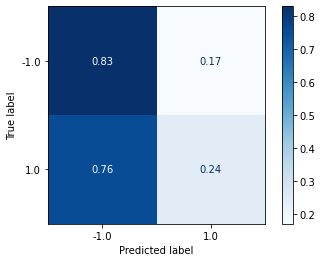

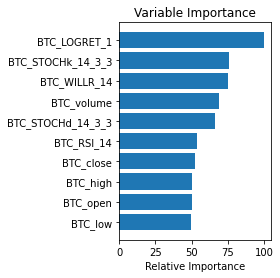

In [24]:
rfc = RandomForestClassifier()

model_results(rfc)

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

train_pred_probs = rfc.predict_proba(X_train)
pred_probs = pd.Series(train_pred_probs[:, 1])
x, y, _ = roc_curve(y_train, pred_probs)
roc_auc = auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In line with what our correlation matrices depicted BTC metrics and indicators show themselve to be relatively important for predicting ETH returns.

##XGBoost Classifier


| Mean CV Train Accuracy Score: 0.5170671550671551 
| Mean CV Test Accuracy Score: 0.5726482213438735 
| ROC_AUC_Score: 0.5306254029658285
              precision    recall  f1-score   support

        -1.0       0.41      0.76      0.53        94
         1.0       0.56      0.22      0.32       132

    accuracy                           0.44       226
   macro avg       0.48      0.49      0.42       226
weighted avg       0.50      0.44      0.40       226



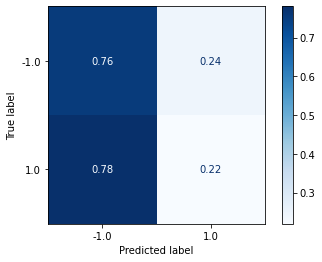

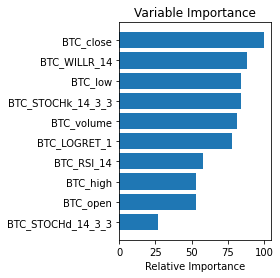

In [25]:
xgb = XGBClassifier()

model_results(xgb)

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

train_pred_probs = rfc.predict_proba(X_train)
pred_probs = pd.Series(train_pred_probs[:, 1])
x, y, _ = roc_curve(y_train, pred_probs)
roc_auc = auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#Feature Selection

It would appear that BTC metrics and indicators display greater relative importance on ETH returns than anything else. As we move onto hyperparameter tuning we'll focus on using only BTC and ETH metrics/indicators for our model(s), so as to curb the curse of dimensionality.

In [26]:
#Create new dataframe containing only BTC and ETH metrics/indicators
btc_eth_cols = final_df.columns.str.contains('ETH', 'BTC')
hptuning_df = final_df.loc[:, btc_eth_cols].join(final_df['Target'])
hptuning_df.head()

,ETH_open,ETH_high,ETH_low,ETH_close,ETH_volume,ETH_LOGRET_1,ETH_STOCHk_14_3_3,ETH_STOCHd_14_3_3,ETH_WILLR_14,ETH_RSI_14,ETH_MACD_12_26_9,ETH_MACDh_12_26_9,ETH_MACDs_12_26_9,ETH_ROC_1,ETH_Z_30,IsETHReturnPositive,Target
date,,,,,,,,,,,,,,,,,
2017-12-29,717.23,758.00,709.00,732.67,44816.84,0.021299,61.940379,63.414237,-37.216802,62.158924,70.247333,-12.496003,82.743336,2.152726,0.282912,1.0,-1.0
2017-12-30,732.67,740.72,659.06,698.46,59596.87,-0.047817,58.298103,61.280939,-46.487805,57.117486,63.791645,-15.161353,78.952998,-4.669224,0.186140,-1.0,1.0
2017-12-31,698.46,759.08,687.03,743.48,24771.96,0.062464,60.669377,60.302620,-34.287263,61.538431,61.598138,-13.883888,75.482026,6.445609,0.275048,1.0,1.0
2018-01-01,743.48,768.87,722.02,752.78,29181.94,0.012431,62.485998,60.484493,-31.766938,62.400766,59.919485,-12.450032,72.369518,1.250874,0.278361,1.0,1.0
2018-01-02,752.78,888.00,752.78,858.60,67628.49,0.131530,75.449633,66.201669,-7.596899,70.504339,66.362940,-4.805262,71.168202,14.057228,0.502553,1.0,1.0


In [27]:
hpt_X = hptuning_df.drop(columns='Target')
hpt_y = hptuning_df['Target']

X_train, X_test, y_train, y_test = train_test_split(hpt_X, hpt_y, test_size=0.2, shuffle=False)

##RandomizedGridSearch for hyperparameter tuning

In [28]:
# Create hyperparameter tuning function

def parameter_tuning(model):
  time_start = time.time()

# Create pipeline to standardize features
  pipe = Pipeline(steps=[
      ('scaler', MinMaxScaler()),
      #('PCA', PCA()),
      ('feature_selection', SelectKBest(k=10)), #defaults to top 10 features
      ('classifier', model)])

  # Specify parameter ranges to search
  param_dist = {'classifier__n_estimators': randint(50,200),
                'classifier__criterion': ['gini', 'entropy'],
                'classifier__max_depth': randint(5,50), 
                'classifier__min_samples_split': randint(25,100), 
                'classifier__max_features':['auto', 'sqrt', 'log2']}
  # Instantiate RandomizedSearchCrossValidation, designate scoring strategy 
  # to evaluate the performance of the cross-validated model on the test set

  cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
  random_cv = RandomizedSearchCV(pipe, param_distributions=param_dist, scoring='accuracy', cv=cv, n_jobs=-1)
  random_cv.fit(X_train, y_train)

  # Output evaluation metrics: 
  y_test_pred = random_cv.predict(X_test)
  print('| Mean Train Accuracy:', random_cv.score(X_train, y_train).mean(),
        '\n| Mean Test Accuracy:', random_cv.score(X_test, y_test).mean(),
        '\n| Mean ROC_AUC_Score:', roc_auc_score(y_test, random_cv.predict_proba(X_test)[:,1]).mean(),
        '\n| Execution time: {}'.format(time.time() - time_start))
  print(classification_report(y_test, y_test_pred))
  plot_confusion_matrix(random_cv, X_test, y_test, normalize='true', cmap='Blues')#, values_format='.5g')
  plt.show()

  #Print Dataframe of model candidates and their parameters
  scores_df = pd.DataFrame(random_cv.cv_results_)
  scores_df = scores_df.sort_values(by=['rank_test_score']).reset_index(drop='index')
  display(scores_df)

| Mean Train Accuracy: 0.7522123893805309 
| Mean Test Accuracy: 0.47345132743362833 
| Mean ROC_AUC_Score: 0.5074145712443585 
| Execution time: 142.2087197303772
              precision    recall  f1-score   support

        -1.0       0.42      0.69      0.52        94
         1.0       0.59      0.32      0.41       132

    accuracy                           0.47       226
   macro avg       0.51      0.50      0.47       226
weighted avg       0.52      0.47      0.46       226



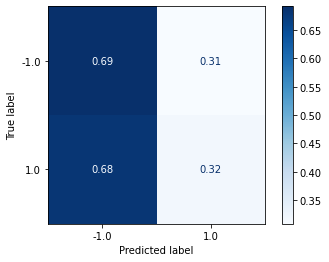

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_samples_split,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
0,0.504130,0.013019,0.021499,0.002046,gini,14,log2,62,136,"{'classifier__criterion': 'gini', 'classifier_...",0.549451,0.549451,0.582418,0.483516,0.511111,0.566667,0.477778,0.644444,0.533333,0.533333,0.560440,0.571429,0.571429,0.516484,0.588889,0.555556,0.566667,0.511111,0.544444,0.611111,0.527473,0.494505,0.571429,0.450549,0.544444,0.466667,0.622222,0.544444,0.566667,0.622222,0.582418,0.560440,0.527473,0.593407,0.511111,0.488889,0.555556,0.600000,0.533333,0.600000,0.637363,0.560440,0.549451,0.538462,0.555556,0.544444,0.544444,0.544444,0.522222,0.522222,0.550227,0.041594,1
1,0.710390,0.022332,0.019406,0.002152,entropy,21,auto,67,123,"{'classifier__criterion': 'entropy', 'classifi...",0.571429,0.560440,0.582418,0.461538,0.488889,0.544444,0.500000,0.633333,0.511111,0.522222,0.571429,0.505495,0.615385,0.505495,0.577778,0.555556,0.544444,0.511111,0.488889,0.533333,0.560440,0.571429,0.472527,0.450549,0.533333,0.433333,0.588889,0.522222,0.600000,0.622222,0.560440,0.560440,0.538462,0.571429,0.522222,0.566667,0.522222,0.622222,0.544444,0.566667,0.637363,0.571429,0.582418,0.593407,0.511111,0.500000,0.544444,0.522222,0.544444,0.533333,0.545101,0.045486,2
2,0.232888,0.007283,0.012216,0.001542,gini,49,auto,76,64,"{'classifier__criterion': 'gini', 'classifier_...",0.538462,0.637363,0.571429,0.483516,0.488889,0.533333,0.533333,0.611111,0.522222,0.522222,0.505495,0.549451,0.593407,0.527473,0.544444,0.566667,0.522222,0.488889,0.477778,0.588889,0.505495,0.549451,0.516484,0.461538,0.555556,0.433333,0.600000,0.555556,0.555556,0.611111,0.505495,0.582418,0.549451,0.549451,0.533333,0.544444,0.511111,0.644444,0.533333,0.577778,0.659341,0.560440,0.571429,0.593407,0.522222,0.488889,0.544444,0.533333,0.522222,0.533333,0.544220,0.045259,3
3,0.420477,0.012234,0.018124,0.001697,gini,49,log2,45,110,"{'classifier__criterion': 'gini', 'classifier_...",0.560440,0.571429,0.593407,0.472527,0.466667,0.555556,0.511111,0.622222,0.533333,0.511111,0.593407,0.516484,0.593407,0.560440,0.544444,0.555556,0.544444,0.544444,0.477778,0.577778,0.560440,0.516484,0.516484,0.461538,0.511111,0.477778,0.600000,0.544444,0.533333,0.622222,0.560440,0.571429,0.582418,0.571429,0.500000,0.577778,0.533333,0.577778,0.511111,0.544444,0.626374,0.549451,0.582418,0.538462,0.555556,0.500000,0.555556,0.500000,0.500000,0.511111,0.543978,0.040550,4
4,0.654002,0.016986,0.028504,0.001175,gini,14,auto,97,189,"{'classifier__criterion': 'gini', 'classifier_...",0.549451,0.626374,0.582418,0.483516,0.444444,0.511111,0.533333,0.611111,0.544444,0.500000,0.571429,0.516484,0.604396,0.472527,0.555556,0.544444,0.533333,0.488889,0.488889,0.555556,0.549451,0.549451,0.516484,0.461538,0.533333,0.411111,0.577778,0.544444,0.566667,0.611111,0.527473,0.571429,0.560440,0.593407,0.533333,0.555556,0.533333,0.588889,0.533333,0.555556,0

In [29]:
rfc = RandomForestClassifier()
parameter_tuning(rfc)

| Mean Train Accuracy: 0.745575221238938 
| Mean Test Accuracy: 0.4911504424778761 
| Mean ROC_AUC_Score: 0.5174887169568021 
| Execution time: 156.9628551006317
              precision    recall  f1-score   support

        -1.0       0.43      0.69      0.53        94
         1.0       0.61      0.35      0.44       132

    accuracy                           0.49       226
   macro avg       0.52      0.52      0.49       226
weighted avg       0.54      0.49      0.48       226



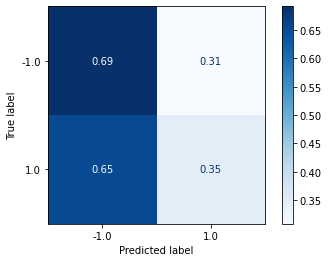

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_samples_split,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
0,0.352274,0.010188,0.015708,0.000703,gini,42,auto,75,96,"{'classifier__criterion': 'gini', 'classifier_...",0.549451,0.549451,0.582418,0.494505,0.488889,0.522222,0.511111,0.611111,0.577778,0.500000,0.538462,0.516484,0.604396,0.527473,0.555556,0.533333,0.577778,0.544444,0.477778,0.555556,0.538462,0.549451,0.516484,0.439560,0.566667,0.444444,0.577778,0.544444,0.566667,0.611111,0.571429,0.582418,0.560440,0.615385,0.544444,0.500000,0.566667,0.588889,0.522222,0.577778,0.615385,0.549451,0.549451,0.604396,0.522222,0.488889,0.533333,0.533333,0.522222,0.544444,0.545321,0.040420,1
1,0.276230,0.007333,0.013874,0.002360,gini,35,auto,80,78,"{'classifier__criterion': 'gini', 'classifier_...",0.549451,0.538462,0.582418,0.494505,0.477778,0.522222,0.566667,0.644444,0.555556,0.533333,0.571429,0.538462,0.571429,0.483516,0.533333,0.533333,0.577778,0.511111,0.477778,0.588889,0.593407,0.538462,0.516484,0.472527,0.511111,0.422222,0.577778,0.500000,0.555556,0.633333,0.560440,0.571429,0.560440,0.582418,0.544444,0.511111,0.544444,0.600000,0.522222,0.588889,0.648352,0.538462,0.571429,0.593407,0.511111,0.488889,0.544444,0.511111,0.544444,0.522222,0.544650,0.044367,2
2,0.940025,0.025577,0.023787,0.001061,entropy,34,log2,70,166,"{'classifier__criterion': 'entropy', 'classifi...",0.538462,0.571429,0.582418,0.494505,0.488889,0.544444,0.511111,0.633333,0.522222,0.522222,0.527473,0.494505,0.604396,0.494505,0.577778,0.533333,0.555556,0.500000,0.511111,0.566667,0.527473,0.593407,0.505495,0.450549,0.533333,0.466667,0.600000,0.511111,0.555556,0.633333,0.571429,0.549451,0.571429,0.538462,0.544444,0.555556,0.544444,0.588889,0.511111,0.566667,0.659341,0.516484,0.549451,0.593407,0.544444,0.544444,0.533333,0.522222,0.488889,0.500000,0.542904,0.042472,3
3,0.559950,0.016876,0.016178,0.000543,entropy,47,log2,95,105,"{'classifier__criterion': 'entropy', 'classifi...",0.560440,0.593407,0.593407,0.494505,0.477778,0.544444,0.544444,0.600000,0.544444,0.477778,0.560440,0.549451,0.593407,0.483516,0.577778,0.566667,0.544444,0.488889,0.488889,0.588889,0.549451,0.527473,0.505495,0.461538,0.533333,0.411111,0.577778,0.522222,0.555556,0.633333,0.538462,0.582418,0.549451,0.549451,0.533333,0.488889,0.500000,0.611111,0.466667,0.544444,0.626374,0.560440,0.538462,0.593407,0.555556,0.488889,0.566667,0.511111,0.588889,0.533333,0.541553,0.045826,4
4,0.834133,0.016855,0.022376,0.001843,entropy,11,sqrt,62,151,"{'classifier__criterion': 'entropy', 'classifi...",0.549451,0.560440,0.582418,0.472527,0.511111,0.533333,0.488889,0.633333,0.533333,0.477778,0.560440,0.538462,0.571429,0.505495,0.577778,0.544444,0.555556,0.511111,0.500000,0.544444,0.571429,0.582418,0.516484,0.483516,0.477778,0.411111,0.611111,0.533333,0.566667,0.633333,0.538462,0.560440,0.527473,0.571429,0.522222,0.555556,0.488889,0.600000,0.488889,0.566

In [30]:
xgb = XGBClassifier()
parameter_tuning(rfc)

## Reassessment
Looks like we actually lost out on some predictive power, so let's switch back to the original testing and training sets!

In [31]:
X = final_df.drop(columns=eth_cols)
y = final_df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

| Mean Train Accuracy: 0.7721238938053098 
| Mean Test Accuracy: 0.5088495575221239 
| Mean ROC_AUC_Score: 0.5228078658929722 
| Execution time: 171.7222716808319
              precision    recall  f1-score   support

        -1.0       0.44      0.70      0.54        94
         1.0       0.64      0.37      0.47       132

    accuracy                           0.51       226
   macro avg       0.54      0.54      0.51       226
weighted avg       0.56      0.51      0.50       226



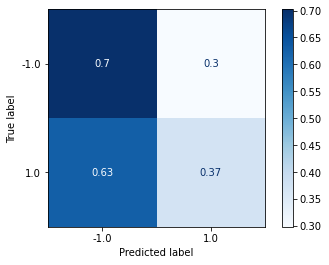

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_samples_split,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
0,0.386335,0.012255,0.011501,0.002170,entropy,34,sqrt,94,65,"{'classifier__criterion': 'entropy', 'classifi...",0.472527,0.516484,0.538462,0.516484,0.533333,0.488889,0.500000,0.544444,0.577778,0.500000,0.571429,0.549451,0.571429,0.571429,0.500000,0.522222,0.577778,0.500000,0.488889,0.466667,0.527473,0.505495,0.527473,0.538462,0.488889,0.455556,0.588889,0.555556,0.533333,0.600000,0.494505,0.527473,0.428571,0.472527,0.522222,0.533333,0.500000,0.555556,0.533333,0.566667,0.582418,0.483516,0.560440,0.571429,0.488889,0.477778,0.566667,0.488889,0.544444,0.566667,0.525883,0.038884,1
1,0.322856,0.008670,0.014766,0.000919,gini,17,log2,75,85,"{'classifier__criterion': 'gini', 'classifier_...",0.483516,0.560440,0.571429,0.483516,0.511111,0.533333,0.466667,0.511111,0.611111,0.522222,0.582418,0.527473,0.560440,0.582418,0.544444,0.488889,0.555556,0.488889,0.466667,0.488889,0.461538,0.571429,0.472527,0.494505,0.533333,0.444444,0.555556,0.522222,0.488889,0.644444,0.483516,0.516484,0.428571,0.538462,0.477778,0.488889,0.522222,0.544444,0.511111,0.588889,0.593407,0.560440,0.549451,0.593407,0.511111,0.533333,0.544444,0.477778,0.488889,0.588889,0.525419,0.046148,2
2,0.985970,0.014910,0.021550,0.000674,entropy,15,log2,25,141,"{'classifier__criterion': 'entropy', 'classifi...",0.472527,0.582418,0.571429,0.450549,0.533333,0.511111,0.500000,0.477778,0.544444,0.544444,0.560440,0.516484,0.571429,0.549451,0.566667,0.500000,0.600000,0.500000,0.544444,0.477778,0.461538,0.450549,0.472527,0.593407,0.555556,0.422222,0.577778,0.577778,0.488889,0.622222,0.461538,0.582418,0.406593,0.461538,0.455556,0.488889,0.500000,0.588889,0.555556,0.544444,0.593407,0.538462,0.494505,0.549451,0.533333,0.533333,0.566667,0.511111,0.500000,0.544444,0.524147,0.049938,3
3,1.204794,0.430047,0.029797,0.011265,entropy,46,log2,96,165,"{'classifier__criterion': 'entropy', 'classifi...",0.483516,0.549451,0.571429,0.450549,0.544444,0.522222,0.455556,0.477778,0.555556,0.533333,0.593407,0.538462,0.549451,0.560440,0.500000,0.488889,0.588889,0.500000,0.444444,0.511111,0.483516,0.505495,0.472527,0.505495,0.511111,0.411111,0.588889,0.544444,0.477778,0.633333,0.505495,0.549451,0.439560,0.505495,0.522222,0.533333,0.511111,0.588889,0.477778,0.555556,0.571429,0.593407,0.538462,0.571429,0.522222,0.500000,0.566667,0.477778,0.488889,0.533333,0.522103,0.046090,4
4,0.661790,0.011829,0.028049,0.002279,gini,12,auto,66,177,"{'classifier__criterion': 'gini', 'classifier_...",0.472527,0.527473,0.571429,0.450549,0.511111,0.522222,0.455556,0.500000,0.544444,0.522222,0.582418,0.538462,0.560440,0.549451,0.544444,0.511111,0.544444,0.466667,0.488889,0.488889,0.505495,0.450549,0.483516,0.527473,0.466667,0.444444,0.622222,0.577778,0.522222,0.644444,0.472527,0.527473,0.450549,0.527473,0.500000,0.455556,0.500000,0.555556,0.544444,0.600

In [32]:
rfc = RandomForestClassifier()
parameter_tuning(rfc)

| Mean Train Accuracy: 0.7776548672566371 
| Mean Test Accuracy: 0.5088495575221239 
| Mean ROC_AUC_Score: 0.5181334622823984 
| Execution time: 171.12475204467773
              precision    recall  f1-score   support

        -1.0       0.45      0.74      0.56        94
         1.0       0.65      0.34      0.45       132

    accuracy                           0.51       226
   macro avg       0.55      0.54      0.50       226
weighted avg       0.57      0.51      0.49       226



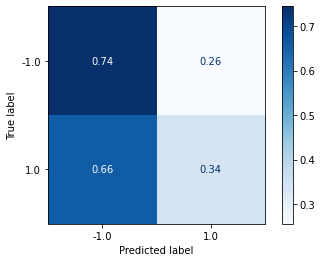

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_samples_split,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
0,0.785991,0.019432,0.020445,0.001569,entropy,17,sqrt,85,133,"{'classifier__criterion': 'entropy', 'classifi...",0.494505,0.538462,0.615385,0.472527,0.522222,0.466667,0.455556,0.511111,0.588889,0.477778,0.593407,0.538462,0.560440,0.582418,0.488889,0.533333,0.622222,0.533333,0.477778,0.500000,0.472527,0.516484,0.472527,0.516484,0.511111,0.422222,0.566667,0.600000,0.533333,0.622222,0.472527,0.549451,0.439560,0.516484,0.488889,0.488889,0.511111,0.577778,0.522222,0.566667,0.538462,0.604396,0.527473,0.582418,0.466667,0.555556,0.544444,0.500000,0.533333,0.555556,0.526977,0.048418,1
1,0.684716,0.011497,0.019495,0.000735,entropy,7,auto,54,132,"{'classifier__criterion': 'entropy', 'classifi...",0.450549,0.604396,0.538462,0.472527,0.522222,0.488889,0.466667,0.466667,0.566667,0.588889,0.604396,0.472527,0.505495,0.604396,0.544444,0.555556,0.588889,0.488889,0.477778,0.500000,0.516484,0.450549,0.505495,0.516484,0.488889,0.433333,0.588889,0.522222,0.511111,0.600000,0.472527,0.549451,0.417582,0.527473,0.522222,0.511111,0.533333,0.577778,0.477778,0.577778,0.549451,0.571429,0.538462,0.560440,0.466667,0.522222,0.600000,0.488889,0.488889,0.566667,0.523238,0.049005,2
2,0.549751,0.009792,0.026124,0.003034,gini,6,log2,70,162,"{'classifier__criterion': 'gini', 'classifier_...",0.472527,0.538462,0.604396,0.472527,0.511111,0.522222,0.466667,0.466667,0.611111,0.522222,0.560440,0.505495,0.505495,0.571429,0.577778,0.488889,0.588889,0.477778,0.466667,0.511111,0.527473,0.505495,0.505495,0.494505,0.511111,0.433333,0.544444,0.533333,0.488889,0.633333,0.483516,0.560440,0.472527,0.505495,0.544444,0.500000,0.511111,0.544444,0.500000,0.544444,0.549451,0.560440,0.560440,0.571429,0.466667,0.533333,0.577778,0.511111,0.477778,0.566667,0.523216,0.043030,3
3,1.052398,0.028583,0.023355,0.001678,entropy,19,auto,45,157,"{'classifier__criterion': 'entropy', 'classifi...",0.483516,0.505495,0.571429,0.483516,0.533333,0.500000,0.477778,0.511111,0.555556,0.533333,0.571429,0.538462,0.571429,0.560440,0.488889,0.522222,0.577778,0.511111,0.511111,0.522222,0.461538,0.472527,0.461538,0.549451,0.500000,0.433333,0.566667,0.577778,0.466667,0.633333,0.450549,0.549451,0.450549,0.483516,0.477778,0.488889,0.511111,0.566667,0.522222,0.555556,0.593407,0.516484,0.549451,0.549451,0.511111,0.577778,0.566667,0.500000,0.488889,0.588889,0.523028,0.043982,4
4,0.232928,0.008072,0.011465,0.001693,gini,33,sqrt,73,59,"{'classifier__criterion': 'gini', 'classifier_...",0.483516,0.538462,0.516484,0.461538,0.533333,0.522222,0.488889,0.533333,0.566667,0.488889,0.604396,0.527473,0.560440,0.549451,0.511111,0.477778,0.566667,0.511111,0.488889,0.500000,0.516484,0.505495,0.472527,0.571429,0.500000,0.444444,0.522222,0.566667,0.466667,0.633333,0.472527,0.571429,0.417582,0.516484,0.477778,0.544444,0.500000,0.566667,0.511111,0.5666

In [33]:
xgb = XGBClassifier()
parameter_tuning(rfc)

#LSTM

In [34]:
X = final_df.drop(columns='Target').values
y = final_df.Target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [35]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((904, 1, 76), (904,), (226, 1, 76), (226,))

In [36]:
# Scaling did not end up making any difference for the accuracy results
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

In [37]:
# design network
model = Sequential()
es = EarlyStopping(monitor='val_accuracy', verbose=1)
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(200))
model.add(Dropout(0.2))
model.add(Dense(1, activation='softmax'))

In [38]:
time_start = time.time()

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
# fit network
history = model.fit(X_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=100, 
                    validation_data=(X_test, y_test), 
                    callbacks=[es], 
                    shuffle=False)

Epoch 1/100
10/10 [==============================] - 5s 149ms/step - loss: 0.7020 - accuracy: 0.4810 - val_loss: 0.6617 - val_accuracy: 0.5841
Epoch 2/100
10/10 [==============================] - 1s 62ms/step - loss: 0.6254 - accuracy: 0.4810 - val_loss: 0.6194 - val_accuracy: 0.5841
Epoch 00002: early stopping


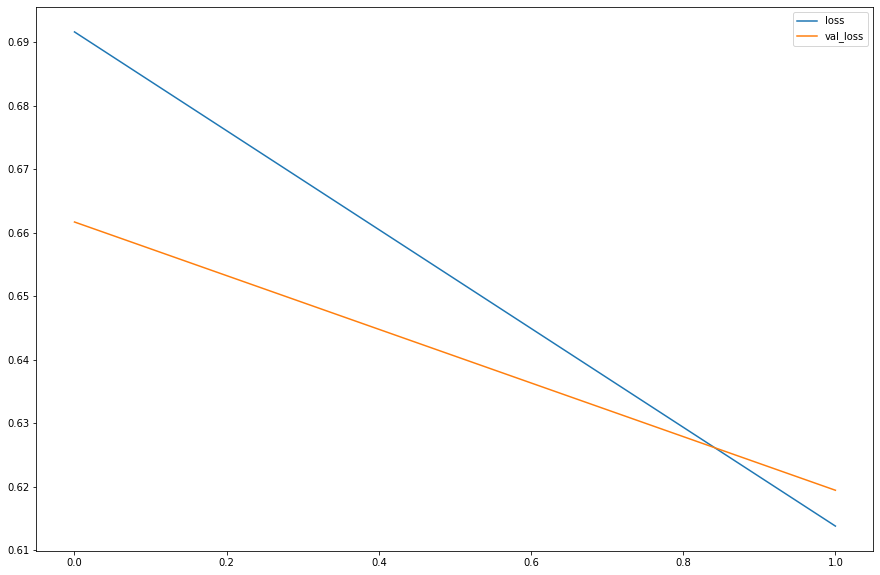

In [39]:
model_df = pd.DataFrame(history.history)
ax=model_df[['loss', 'val_loss']].plot(figsize=(15,10))

#Conclusion

Ultimately, after EXTENSIVE AND EXHAUSTIVE tuning, all three models showed equivalent proficiency at classifying whether the next day's returns would be positive("Up Day") or negative("Down Day"): **approximately 57-58%**, but the LSTM executed the classification task with extreme speed.

While 58% is of course better than a coin-flip, we still think there is room for improvement. 

## Future Considerations:
1. SO MANY INDICATORS
> More time permitting, it would have been helpful to  iterate through ALL the possible indicators from the Pandas-ta library and hone in on those most correlated with ETH returns. Building our models from there.
2. This prediction could serve as a signal to be built into an algorithmic trader, either in its current state or after further development.